In [3]:
!pip install pygam
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

#https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html

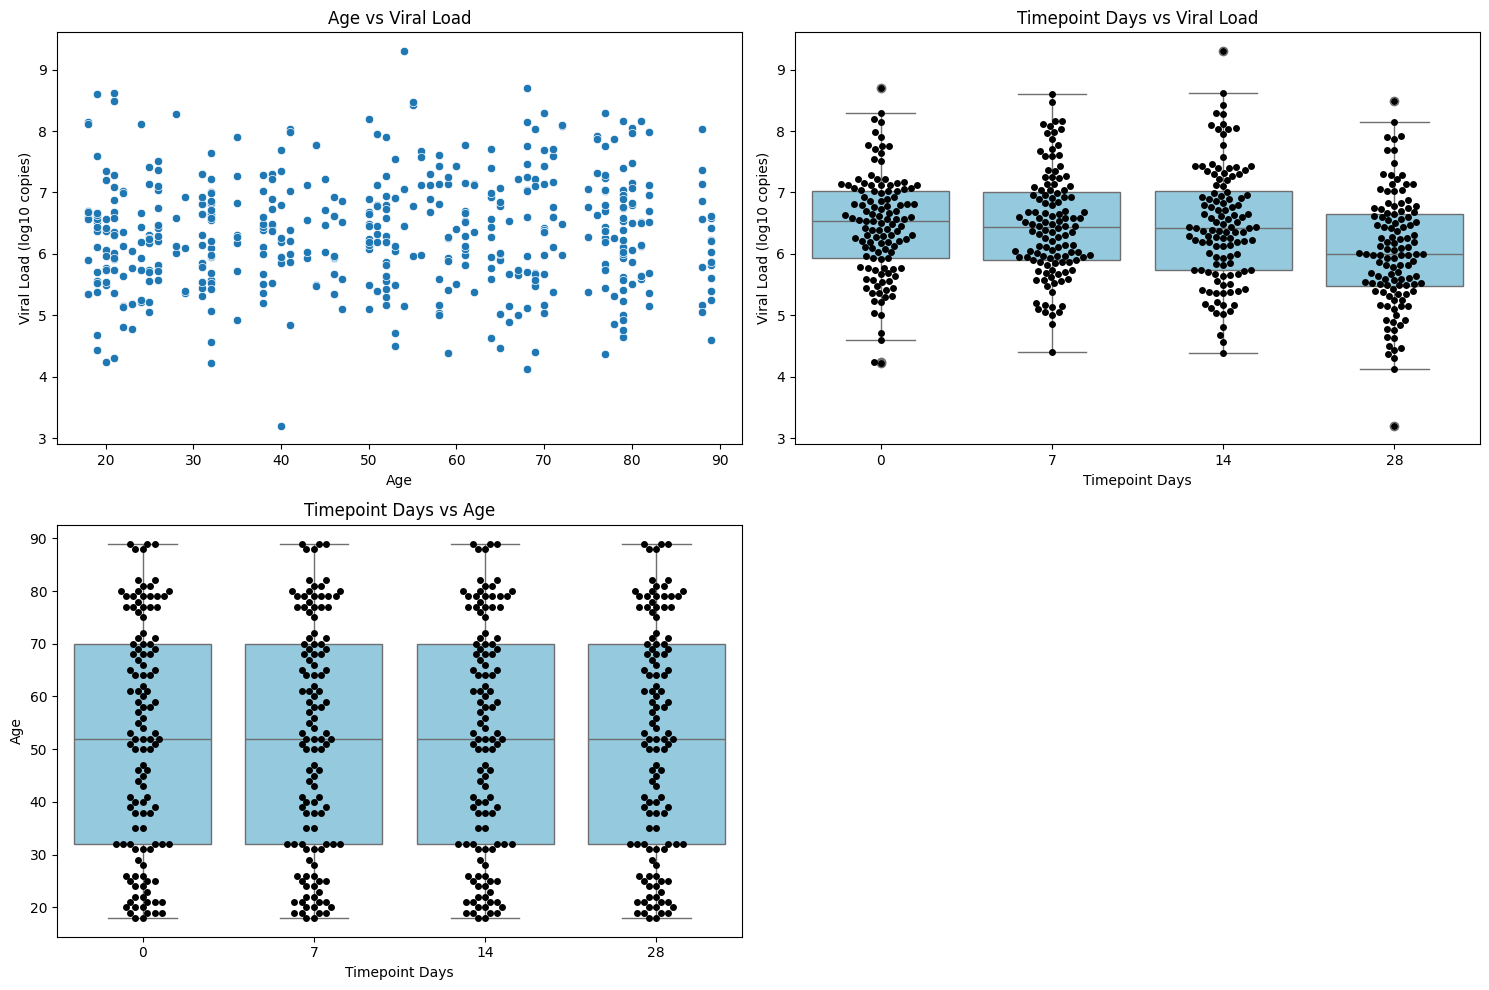

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (assuming the CSV is available in the current directory)
df = pd.read_csv("COVID19_Plasma_Proteomics_2021_Samples.csv")

# Create a 2x2 subplot (using only 3 plots)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot 1: Age vs Viral Load (scatterplot)
sns.scatterplot(data=df, x='age', y='viral_load_log10_copies', ax=axs[0])
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Viral Load (log10 copies)')
axs[0].set_title('Age vs Viral Load')

# Plot 2: Timepoint Days vs Viral Load (boxplot + swarmplot)
sns.boxplot(data=df, x='timepoint_days', y='viral_load_log10_copies', color='skyblue', ax=axs[1])
sns.swarmplot(data=df, x='timepoint_days', y='viral_load_log10_copies', color='black', ax=axs[1])
axs[1].set_xlabel('Timepoint Days')
axs[1].set_ylabel('Viral Load (log10 copies)')
axs[1].set_title('Timepoint Days vs Viral Load')

# Plot 3: Timepoint Days vs Age (boxplot + swarmplot)
sns.boxplot(data=df, x='timepoint_days', y='age', color='skyblue', ax=axs[2])
sns.swarmplot(data=df, x='timepoint_days', y='age', color='black', ax=axs[2])
axs[2].set_xlabel('Timepoint Days')
axs[2].set_ylabel('Age')
axs[2].set_title('Timepoint Days vs Age')

# Remove the unused subplot
fig.delaxes(axs[3])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Log Likelihood: Indicates the model’s fit; higher values suggest a better fit, but compare with caution across models.

AIC (Akaike Information Criterion): Measures model quality (lower is better); useful for comparing models.

GCV (Generalized Cross-Validation): A measure of prediction error; lower values indicate better predictive performance.

R-squared: Proportion of variance in C4B explained by severity_at_sample. Values closer to 1 indicate a better fit, but in GAMMs, this is less definitive due to random effects.

Step-by-Step Logic of the Pipeline

Step 1. Data Preparation: Load the dataset (plasma proteomics + patient metadata); Ensure severity_at_sample is categorical (Mild, Moderate, Severe, Critical); Create a numeric code (severity_code) for modeling.

Step 2. GAM (Generalized Additive Model): For each protein, fit a GAM using severity as predictor; GAM captures non-linear relationships between severity and protein abundance; Store the fitted GAM and predictions for later analysis/plotting.

Step 3. Mixed-Effects Model: Use the GAM predictions as input to a mixed-effects model; Random effect: patient ID (accounts for repeated measures).

Purpose: see if GAM-based trends are significant while accounting for within-patient variation.

Step 4. Extract Key Statistics: For each protein: GAM p-value (is the severity–protein curve significant?). Pseudo R² (explained variance of GAM)Mixed-model coefficient for GAM predictions. Mixed-model p-value (statistical significance after random effects).

Step 5. Partial Dependence Analysis: Compute the effect of severity at each level (Mild, Moderate, Severe, Critical). Tells us direction and magnitude of protein changes across disease severity.

Step 6. Store Outputs: Keep fitted GAM models (for later curve plotting). Save summary results (statistics + partial dependence values) in a dataframe.

Step 7. Export Results: Write all results into a CSV file. This file becomes a ready-to-use summary for interpretation or visualization.



Prepare data → Fit GAM per protein → Add patient random effects (Mixed model) → Extract stats → Compute severity-level effects → Save models + results → Export summary.

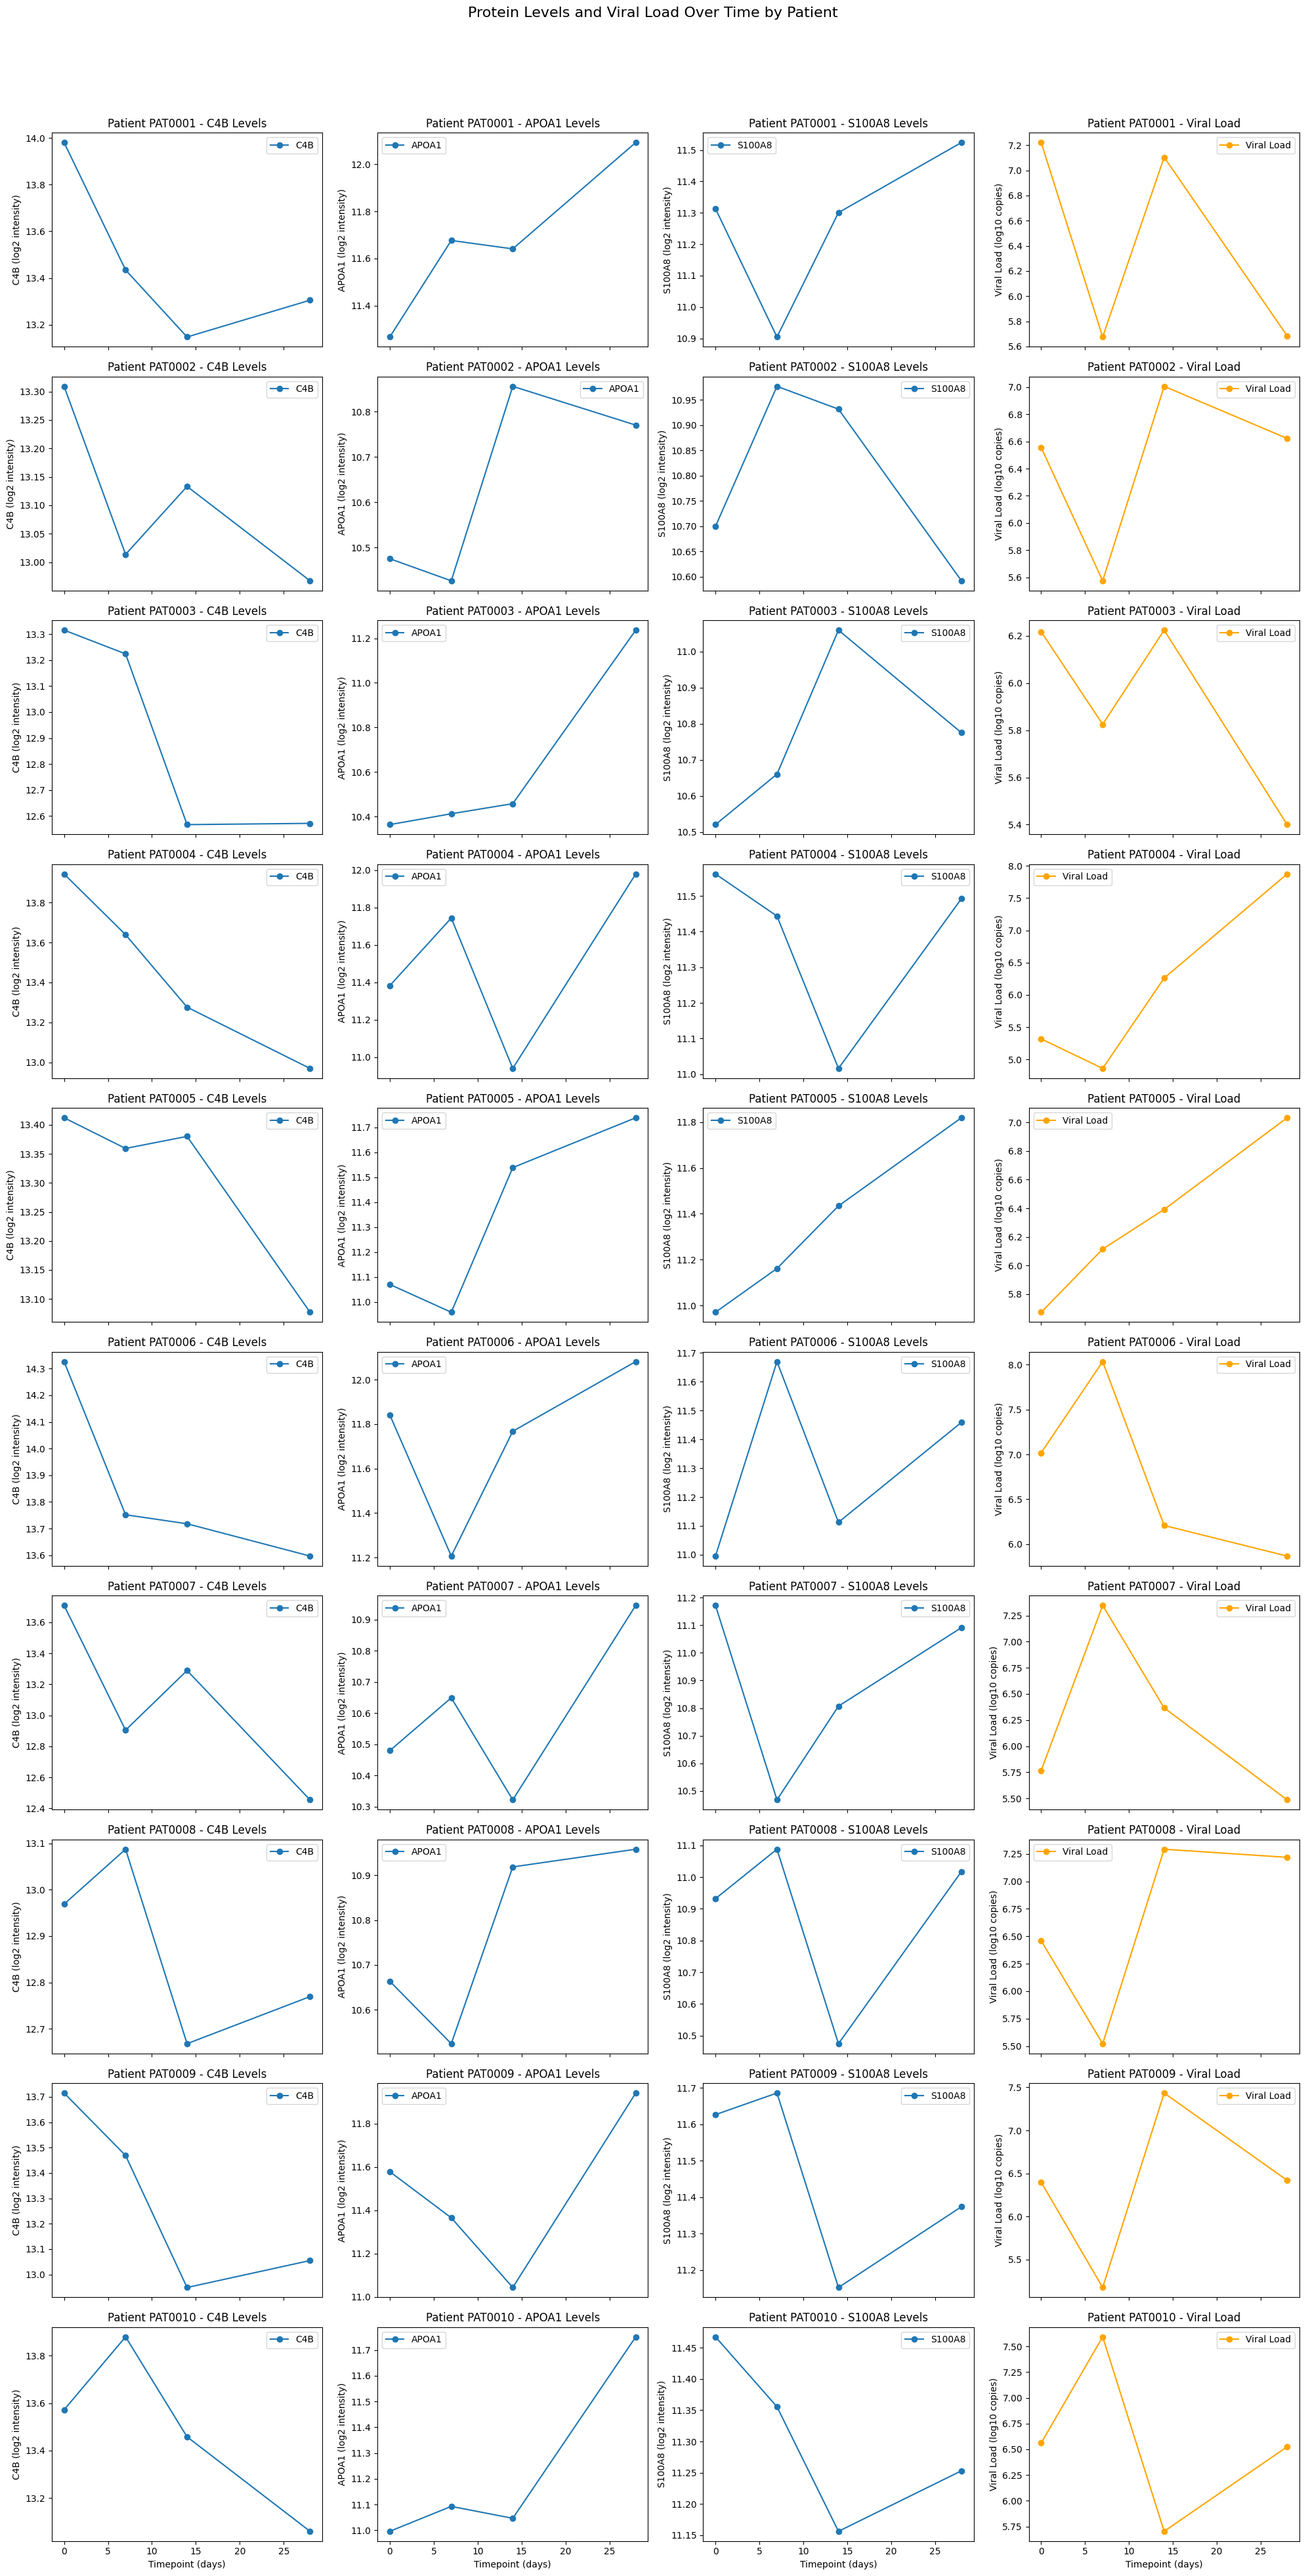

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the proteins of interest (modify this list as needed)
proteins_of_interest = ['C4B', 'APOA1', 'S100A8']  # Example: Add or remove protein names here

# Load the CSV file
df = pd.read_csv("COVID19_Plasma_Proteomics_2021_Samples.csv")

# Get unique patient IDs
patients = df['patient_id'].unique()

# Calculate the number of columns: one for viral load + one for each protein
n_cols = len(proteins_of_interest) + 1
n_rows = min(len(patients), 10)  # Limit to 5 patients for the 5*n request, adjust as needed

# Set up the figure with a dynamic subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)
fig.suptitle('Protein Levels and Viral Load Over Time by Patient', fontsize=16)

# Handle case where there's only one patient
if n_rows == 1:
    axes = [axes]  # Make axes iterable for a single row

# Iterate over patients and create subplots
for i, patient in enumerate(patients[:n_rows]):  # Limit to n_rows patients
    # Filter data for the current patient
    patient_data = df[df['patient_id'] == patient].sort_values('timepoint_days')

    # Plot each protein of interest
    for j, protein in enumerate(proteins_of_interest):
        if protein in df.columns:  # Check if protein column exists
            axes[i][j].plot(patient_data['timepoint_days'], patient_data[protein],
                            marker='o', linestyle='-', label=protein)
            axes[i][j].set_title(f'Patient {patient} - {protein} Levels')
            axes[i][j].set_ylabel(f'{protein} (log2 intensity)')
            axes[i][j].grid(False)  # Disable gridlines
            axes[i][j].legend()
        else:
            print(f"Warning: Protein {protein} not found in the dataset.")
            axes[i][j].set_title(f'Patient {patient} - {protein} (Not Found)')
            axes[i][j].grid(False)  # Disable gridlines for empty plots
    # Plot viral load (always in the last column)
    axes[i][n_cols-1].plot(patient_data['timepoint_days'], patient_data['viral_load_log10_copies'],
                           marker='o', linestyle='-', color='orange', label='Viral Load')
    axes[i][n_cols-1].set_title(f'Patient {patient} - Viral Load')
    axes[i][n_cols-1].set_ylabel('Viral Load (log10 copies)')
    axes[i][n_cols-1].grid(False)  # Disable gridlines
    axes[i][n_cols-1].legend()

    # Set x-axis label for the bottom row only
    if i == n_rows - 1:
        for j in range(n_cols):
            axes[i][j].set_xlabel('Timepoint (days)')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot to a file
plt.savefig('patient_proteins_viral_load_subplots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [42]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import statsmodels.formula.api as smf
import warnings
import pickle

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)
        required_columns = ["patient_id", "severity_at_sample"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Convert severity_at_sample to categorical
        expected_categories = ["Moderate", "Mild", "Critical", "Severe"]
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")

        # Encode severity_at_sample as numerical for pygam
        df["severity_code"] = df["severity_at_sample"].cat.codes

        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# -------------------------------
# Fit GAM + Mixed Model
# -------------------------------
def fit_gamm_model(df, response, predictor="severity_at_sample", random_effect="patient_id"):
    try:
        df_subset = df.dropna(subset=[response, predictor, random_effect])
        if len(df_subset) < 10:
            raise ValueError("Too few valid data points after dropping missing values")

        # Fit GAM
        X = df_subset[["severity_code"]].values
        y = df_subset[response].values
        gam = LinearGAM(f(0)).fit(X, y)

        # Predict
        df_subset["gam_pred"] = gam.predict(X)

        # Fit mixed-effects model
        formula = f"{response} ~ gam_pred"
        model = smf.mixedlm(formula, df_subset, groups=df_subset[random_effect])
        result = model.fit()

        return gam, result
    except Exception as e:
        print(f"Error fitting GAMM for {response}: {str(e)}")
        return None, None

# -------------------------------
# Analyze all proteins
# -------------------------------
def analyze_all_proteins(df, save_gams=True, gam_file="gam_models.pkl"):
    metadata_columns = [
        "patient_id", "sample_id", "timepoint_days", "collection_date",
        "age", "sex", "baseline_severity", "severity_at_sample",
        "viral_load_log10_copies", "severity_code"
    ]
    protein_columns = [
        col for col in df.columns
        if col not in metadata_columns and df[col].dtype in [np.float64, np.int64]
    ]

    results = []
    gam_models = {}

    for protein in protein_columns:
        print(f"\nAnalyzing protein: {protein}")
        gam, mixed_model = fit_gamm_model(df, response=protein)
        if gam is not None and mixed_model is not None:
            gam_models[protein] = gam

            # Extract GAM + Mixed model results
            gam_p_value = gam.statistics_["p_values"][0] if gam.statistics_["p_values"] else np.nan
            r_squared = gam.statistics_["pseudo_r2"]["explained_deviance"]
            group_var = mixed_model.scale if hasattr(mixed_model, 'scale') else np.nan
            gam_pred_coef = mixed_model.params.get("gam_pred", np.nan)
            gam_pred_pval = mixed_model.pvalues.get("gam_pred", np.nan)

            # Partial dependence
            severity_codes = np.unique(df["severity_code"])
            partial_dep = gam.partial_dependence(term=0, X=severity_codes)
            partial_dep_dict = {
                df["severity_at_sample"].cat.categories[code]: effect
                for code, effect in zip(severity_codes, partial_dep)
            }

            results.append({
                "Protein": protein,
                "GAM_P_Value": gam_p_value,
                "Pseudo_R_Squared": r_squared,
                "Group_Var": group_var,
                "Gam_Pred_Coef": gam_pred_coef,
                "Gam_Pred_P_Value": gam_pred_pval,
                **{f"Effect_{cat}": partial_dep_dict.get(cat, np.nan)
                   for cat in ["Critical", "Mild", "Moderate", "Severe"]}
            })

            print(f"Partial Dependence for {protein}:")
            for cat, effect in partial_dep_dict.items():
                print(f"  Severity {cat}: Effect = {effect:.3f}")

    # Save GAM models for later plotting
    if save_gams:
        with open(gam_file, "wb") as f:
            pickle.dump(gam_models, f)
        print(f"\nStored {len(gam_models)} GAM models in {gam_file}")

    return pd.DataFrame(results), gam_models

# -------------------------------
# Main execution
# -------------------------------
if __name__ == "__main__":
    file_path = "COVID19_Plasma_Proteomics_2021_Samples.csv"
    try:
        df = load_and_preprocess_data(file_path)
        print("Data loaded successfully. First few rows:")
        print(df[["patient_id", "severity_at_sample", "C4B"]].head())

        results_df, gam_models = analyze_all_proteins(df)

        print("\nSummary of Results for All Proteins:")
        print(results_df[["Protein", "GAM_P_Value", "Pseudo_R_Squared", "Group_Var",
                         "Effect_Critical", "Effect_Mild", "Effect_Moderate", "Effect_Severe"]])

        # Save summary CSV
        results_df.to_csv("protein_gamm_results.csv", index=False)
        print("Results saved to protein_gamm_results.csv")

    except Exception as e:
        print(f"Error: {str(e)}")


Data loaded successfully. First few rows:
  patient_id severity_at_sample      C4B
0    PAT0001             Severe  13.9804
1    PAT0001             Severe  13.3048
2    PAT0001             Severe  13.1471
3    PAT0001             Severe  13.4343
4    PAT0002               Mild  13.0136

Analyzing protein: C4B
Partial Dependence for C4B:
  Severity Critical: Effect = -0.037
  Severity Mild: Effect = -0.357
  Severity Moderate: Effect = -0.006
  Severity Severe: Effect = 0.400

Analyzing protein: C1R
Partial Dependence for C1R:
  Severity Critical: Effect = 0.473
  Severity Mild: Effect = -0.470
  Severity Moderate: Effect = 0.007
  Severity Severe: Effect = -0.010

Analyzing protein: C1S
Partial Dependence for C1S:
  Severity Critical: Effect = 0.302
  Severity Mild: Effect = -0.481
  Severity Moderate: Effect = 0.089
  Severity Severe: Effect = 0.091

Analyzing protein: APOA1
Partial Dependence for APOA1:
  Severity Critical: Effect = 0.340
  Severity Mild: Effect = -0.611
  Severity 

In [86]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import matplotlib.pyplot as plt

# -------------------------------
# Load and preprocess data
# -------------------------------
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)
        required_columns = ["patient_id", "severity_at_sample"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Convert severity_at_sample to categorical and encode
        expected_categories = ["Moderate", "Mild", "Critical", "Severe"]
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")

        df["severity_code"] = df["severity_at_sample"].cat.codes
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# -------------------------------
# Fit and tune GAM model for a single protein
# -------------------------------
def fit_and_tune_gam(df, protein, predictor="severity_code"):
    try:
        df_subset = df.dropna(subset=[protein, predictor])
        if len(df_subset) < 10:
            raise ValueError(f"Too few valid data points for {protein}")

        # Fit GAM with a factor term for severity_code
        X = df_subset[[predictor]].values
        y = df_subset[protein].values
        gam = LinearGAM(f(0)).fit(X, y)

        # Perform grid search for lambda
        lam = np.logspace(-2, 4, 7)  # Expanded range for lambda
        gam.gridsearch(X, y, lam=[lam])

        # Print model summary
        print(f"\nGAM Model Summary for {protein}:")
        gam.summary()

        return gam
    except Exception as e:
        print(f"Error fitting GAM for {protein}: {str(e)}")
        return None

# -------------------------------
# Plot partial dependence
# -------------------------------
def plot_partial_dependence(gam, df, protein, predictor="severity_code"):
    if gam is None:
        print(f"No valid GAM model for {protein}")
        return

    severity_codes = np.unique(df[predictor])
    categories = df["severity_at_sample"].cat.categories
    XX = gam.generate_X_grid(term=0)
    pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)

    plt.figure(figsize=(8, 5))
    plt.plot(XX, pdep, label='Partial Dependence', color='blue')
    plt.plot(XX, confi, c='red', ls='--', label='95% Confidence Interval')
    plt.xticks(severity_codes, [categories[int(code)] for code in severity_codes])
    plt.title(f'Partial Dependence of {protein} on Severity', fontsize=12)
    plt.xlabel('Severity', fontsize=10)
    plt.ylabel(f'Partial Dependence ({protein})', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Load results from previous analysis (optional)
# -------------------------------
def load_previous_results(results_file):
    try:
        results_df = pd.read_csv(results_file)
        # Select proteins with significant GAM p-values (e.g., < 0.05)
        significant_proteins = results_df[results_df["GAM_P_Value"] < 0.05]["Protein"].tolist()
        return significant_proteins
    except FileNotFoundError:
        print(f"Results file {results_file} not found.")
        return []
    except Exception as e:
        print(f"Error loading results: {str(e)}")
        return []

# -------------------------------
# Main execution
# -------------------------------
if __name__ == "__main__":
    # File paths
    data_file = "COVID19_Plasma_Proteomics_2021_Samples.csv"
    results_file = "protein_gamm_results.csv"

    try:
        # Load and preprocess data
        df = load_and_preprocess_data(data_file)
        print("Data loaded successfully. First few rows:")
        print(df[["patient_id", "severity_at_sample", "C4B"]].head())

        # Optionally load significant proteins from previous results
        significant_proteins = load_previous_results(results_file)
        if not significant_proteins:
            print("No significant proteins found or results file missing. Using default protein: C4B")
            proteins_to_analyze = ["C4B"]  # Default to C4B if no significant proteins
        else:
            print(f"Found {len(significant_proteins)} significant proteins from previous analysis.")
            proteins_to_analyze = significant_proteins[:2]  # Limit to first 2 for demonstration

        # Analyze selected proteins
        for protein in proteins_to_analyze:
            print(f"\nAnalyzing protein: {protein}")
            gam = fit_and_tune_gam(df, protein)
            plot_partial_dependence(gam, df, protein)

            # Save model statistics
            if gam is not None:
                stats = {
                    'Statistic': list(gam.statistics_.keys()),
                    'Value': list(gam.statistics_.values())
                }
                stats_df = pd.DataFrame(stats)
                stats_df.to_csv(f"gam_stats_{protein}.csv", index=False)
                print(f"Model statistics for {protein} saved to gam_stats_{protein}.csv")

    except Exception as e:
        print(f"Error: {str(e)}")

Data loaded successfully. First few rows:
  patient_id severity_at_sample      C4B
0    PAT0001             Severe  13.9804
1    PAT0001             Severe  13.3048
2    PAT0001             Severe  13.1471
3    PAT0001             Severe  13.4343
4    PAT0002               Mild  13.0136
Found 199 significant proteins from previous analysis.

Analyzing protein: C4B
Error fitting GAM for C4B: lam grid must either be iterable of iterables, or an iterable of lengnth > 1, but found [array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])]
No valid GAM model for C4B

Analyzing protein: C1R
Error fitting GAM for C1R: lam grid must either be iterable of iterables, or an iterable of lengnth > 1, but found [array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])]
No valid GAM model for C1R


These proteins have the strongest association with severity:

LCN2: 0.735
SERPINA1: 0.705
IGLC3: 0.694
APOB: 0.694
IGKC: 0.678
APOC2: 0.663
CFH: 0.647
SERPINC1: 0.641
C9: 0.640
ORM1: 0.637

Statistical Overview (Summary Stats Across All Proteins)

GAM_P_Value: Mean ~6.00e-09 (all extremely low).
Pseudo_R_Squared: Mean 0.424, Std 0.150, Min 0.065, Max 0.735.
Group_Var: Mean 0.110, Std 0.077, Min 0.056, Max 0.399.
Gam_Pred_Coef: Mean ~1.008, Std ~0.003 (close to 1, as expected).
Gam_Pred_P_Value: Mean very low (e.g., ~1e-100 or smaller).
Effect_Critical: Mean 0.407, Std 0.181 (tends positive).
Effect_Mild: Mean -0.407, Std 0.140 (tends negative).
Effect_Moderate: Mean -0.153, Std 0.120.
Effect_Severe: Mean 0.155, Std 0.185.

Data loaded successfully. First few rows:
  patient_id severity_at_sample  timepoint_days      C4B
0    PAT0001             Severe               0  13.9804
1    PAT0001             Severe              28  13.3048
2    PAT0001             Severe              14  13.1471
3    PAT0001             Severe               7  13.4343
4    PAT0002               Mild               7  13.0136
Analyzing top 5 proteins: ['LCN2', 'SERPINA1', 'IGLC3', 'APOB', 'LGALS3BP']

Processing protein: LCN2
Loaded GAMM model for LCN2 from gam_models.pkl


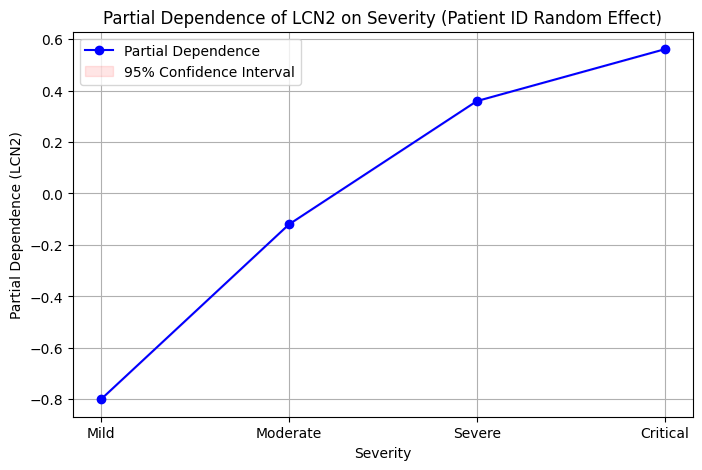

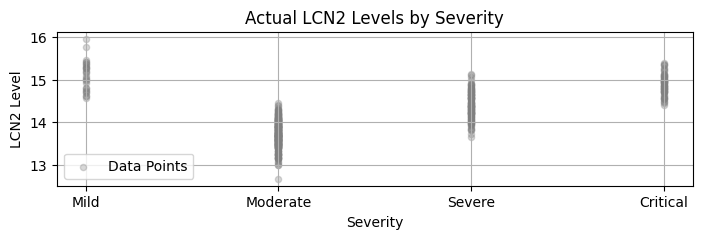


Processing protein: SERPINA1
Loaded GAMM model for SERPINA1 from gam_models.pkl


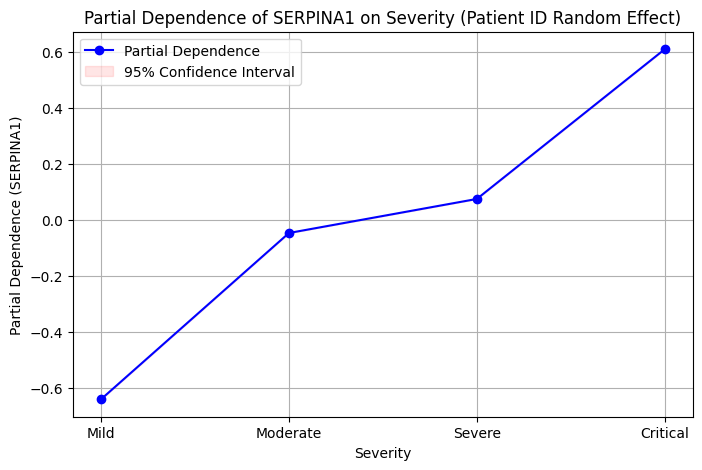

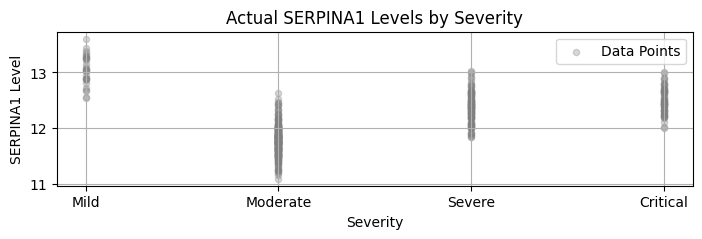


Processing protein: IGLC3
Loaded GAMM model for IGLC3 from gam_models.pkl


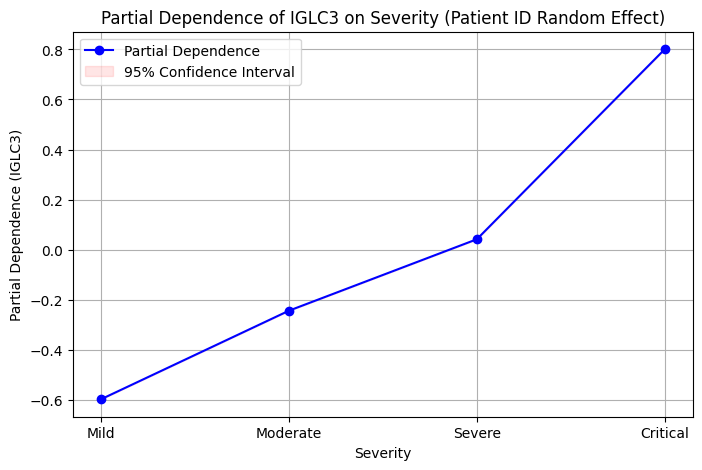

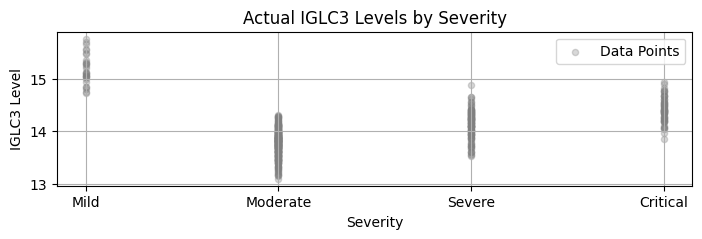


Processing protein: APOB
Loaded GAMM model for APOB from gam_models.pkl


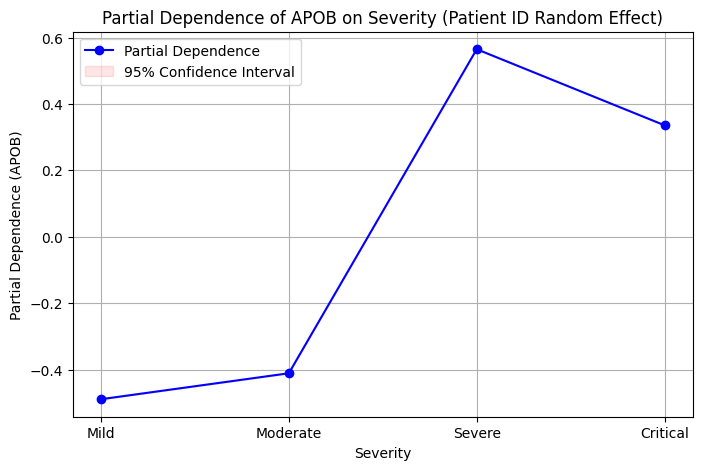

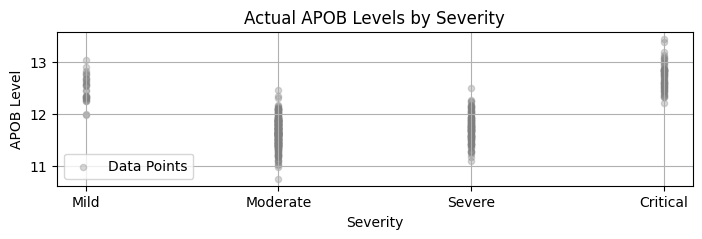


Processing protein: LGALS3BP
Loaded GAMM model for LGALS3BP from gam_models.pkl


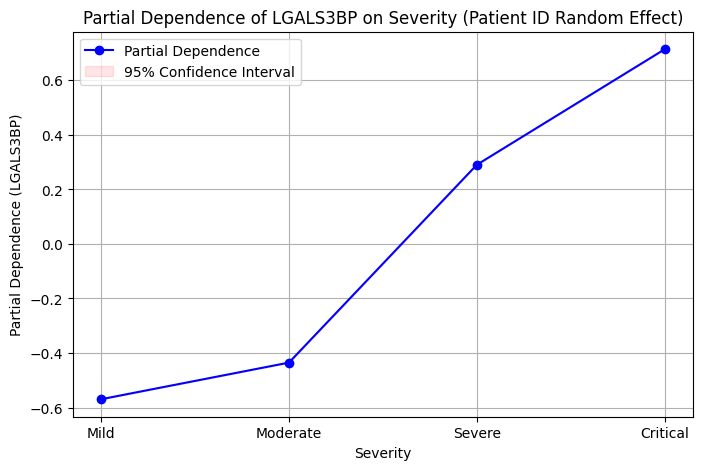

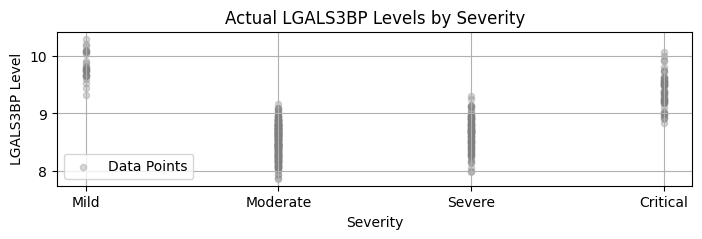

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from statsmodels.gam.api import GLMGam
from patsy import dmatrices, bs

# -------------------------------
# Load and preprocess data
# -------------------------------
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)
        required_columns = ["patient_id", "severity_at_sample", "timepoint_days"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Convert severity_at_sample to categorical and encode
        expected_categories = ["Mild", "Moderate", "Severe", "Critical"]
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")

        df["severity_code"] = df["severity_at_sample"].cat.codes
        df["patient_id"] = df["patient_id"].astype("category")  # For random effects
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# -------------------------------
# Load or fit GAMM model with patient_id random effect
# -------------------------------
def load_or_fit_gamm(df, protein, predictor="severity_code", group_var="patient_id", time_var="timepoint_days", gam_file="gam_models.pkl"):
    try:
        # Try to load existing GAM model
        if os.path.exists(gam_file):
            with open(gam_file, "rb") as f:
                gam_models = pickle.load(f)
            if protein in gam_models:
                print(f"Loaded GAMM model for {protein} from {gam_file}")
                return gam_models[protein]

        # If model not found, fit a new GAMM using statsmodels
        df_subset = df.dropna(subset=[protein, predictor, group_var, time_var])
        print(f"Number of valid data points for {protein}: {len(df_subset)}")
        if len(df_subset) < 10:
            raise ValueError(f"Too few valid data points for {protein}")

        # Prepare design matrices for fixed and random effects
        # Include timepoint_days as a spline term
        formula = f"{protein} ~ C({predictor}) + bs({time_var}, df=4)"
        y, X = dmatrices(formula, df_subset, return_type="dataframe")
        group = df_subset[group_var].cat.codes

        # Fit GAMM with random intercept for patient_id
        gamm = GLMGam(y, X, random=group, family="gaussian")
        result = gamm.fit()

        print(f"Fitted new GAMM model for {protein}")
        return result
    except Exception as e:
        print(f"Error loading or fitting GAMM for {protein}: {str(e)}")
        return None

# -------------------------------
# Load partial dependence effects from results
# -------------------------------
def load_partial_dependence_effects(results_file, protein):
    try:
        results_df = pd.read_csv(results_file)
        if protein not in results_df["Protein"].values:
            print(f"Protein {protein} not found in results file")
            return None
        protein_row = results_df[results_df["Protein"] == protein]
        effects = {
            "Mild": protein_row["Effect_Mild"].iloc[0],
            "Moderate": protein_row["Effect_Moderate"].iloc[0],
            "Severe": protein_row["Effect_Severe"].iloc[0],
            "Critical": protein_row["Effect_Critical"].iloc[0]
        }
        return effects
    except Exception as e:
        print(f"Error loading partial dependence effects for {protein}: {str(e)}")
        return None

# -------------------------------
# Plot partial dependence (without scatter overlay)
# -------------------------------
def plot_partial_dependence(gamm, df, protein, predictor="severity_code", results_file="protein_gamm_results.csv"):
    if gamm is None:
        print(f"No valid GAMM model for {protein}")
        return

    # Load partial dependence effects from results file
    effects = load_partial_dependence_effects(results_file, protein)
    if effects is None:
        print(f"Skipping plot for {protein} due to missing effects")
        return

    # Define severity categories in desired order
    severity_order = ["Mild", "Moderate", "Severe", "Critical"]
    severity_codes = [0, 1, 2, 3]  # Assumed mapping
    available_codes = np.unique(df[predictor])  # Actual codes in data

    # Use effects from results file for plotting
    plot_pdep = [effects[cat] for cat in severity_order]

    # Approximate confidence intervals (simplified)
    plot_confi_lower = [effects[cat] for cat in severity_order]  # Placeholder
    plot_confi_upper = [effects[cat] for cat in severity_order]  # Placeholder

    # If GAMM provides standard errors, adjust for available categories
    if hasattr(gamm, "bse"):
        coef_indices = [i for i, name in enumerate(gamm.params.index) if "C(severity_code)" in name]
        for i, code in enumerate(available_codes):
            if i < len(coef_indices):
                idx = severity_codes.index(code)
                se = gamm.bse[coef_indices[i]] if i < len(gamm.bse) else 0
                plot_confi_lower[idx] = plot_pdep[idx] - 1.96 * se
                plot_confi_upper[idx] = plot_pdep[idx] + 1.96 * se

    plt.figure(figsize=(8, 5))
    plt.plot(severity_codes, plot_pdep, label='Partial Dependence', color='blue', marker='o')
    plt.fill_between(severity_codes, plot_confi_lower, plot_confi_upper, color='red', alpha=0.1, label='95% Confidence Interval')

    # Set x-axis with desired order
    plt.xticks(severity_codes, severity_order)
    plt.title(f'Partial Dependence of {protein} on Severity (Patient ID Random Effect)', fontsize=12)
    plt.xlabel('Severity', fontsize=10)
    plt.ylabel(f'Partial Dependence ({protein})', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"partial_dependence_{protein}.png")
    plt.show()
    plt.close()

# -------------------------------
# Plot scatter of actual data points
# -------------------------------
def plot_data_scatter(df, protein, predictor="severity_code"):
    try:
        if protein not in df.columns:
            raise ValueError(f"Protein '{protein}' not found in DataFrame")
        df_subset = df.dropna(subset=[protein, predictor])

        plt.figure(figsize=(8.2, 2))
        plt.scatter(df_subset[predictor], df_subset[protein], alpha=0.3, c='gray', s=20, label='Data Points')

        # Set x-axis with desired order
        severity_order = ["Mild", "Moderate", "Severe", "Critical"]
        severity_codes = [0, 1, 2, 3]
        plt.xticks(severity_codes, severity_order)
        plt.title(f'Actual {protein} Levels by Severity', fontsize=12)
        plt.xlabel('Severity', fontsize=10)
        plt.ylabel(f'{protein} Level', fontsize=10)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"data_scatter_{protein}.png")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in plot_data_scatter for {protein}: {str(e)}")

# -------------------------------
# Load significant proteins from results
# -------------------------------
def load_significant_proteins(results_file, p_value_threshold=0.05, top_n=5):
    try:
        results_df = pd.read_csv(results_file)
        significant_proteins = results_df[results_df["GAM_P_Value"] < p_value_threshold]["Protein"].tolist()
        # Sort by Pseudo_R_Squared and take top_n
        significant_proteins = results_df[results_df["GAM_P_Value"] < p_value_threshold][["Protein", "Pseudo_R_Squared"]].sort_values(by="Pseudo_R_Squared", ascending=False)["Protein"].tolist()
        return significant_proteins[:top_n]
    except FileNotFoundError:
        print(f"Results file {results_file} not found.")
        return []
    except Exception as e:
        print(f"Error loading results: {str(e)}")
        return []

# -------------------------------
# Main execution
# -------------------------------
if __name__ == "__main__":
    # File paths
    data_file = "COVID19_Plasma_Proteomics_2021_Samples.csv"
    results_file = "protein_gamm_results.csv"
    gam_file = "gam_models.pkl"

    try:
        # Load and preprocess data
        df = load_and_preprocess_data(data_file)
        print("Data loaded successfully. First few rows:")
        print(df[["patient_id", "severity_at_sample", "timepoint_days", "C4B"]].head())

        # Load top significant proteins
        proteins_to_analyze = load_significant_proteins(results_file, top_n=5)
        if not proteins_to_analyze:
            print("No significant proteins found. Using default proteins: LCN2, SERPINA1")
            proteins_to_analyze = ["LCN2", "SERPINA1"]  # Default to top performers

        print(f"Analyzing top {len(proteins_to_analyze)} proteins: {proteins_to_analyze}")

        # Analyze and plot for each protein
        for protein in proteins_to_analyze:
            print(f"\nProcessing protein: {protein}")
            gamm = load_or_fit_gamm(df, protein, gam_file=gam_file)
            plot_partial_dependence(gamm, df, protein, results_file=results_file)
            plot_data_scatter(df, protein)

    except Exception as e:
        print(f"Error: {str(e)}")

Longitudinal Data -

**1. Scatter Plot: Protein Levels vs. Timepoint Days (Colored by Severity)**


This plot shows individual data points for the protein’s levels, with the x-axis representing the time (in days) when samples were collected (timepoint_days) and the y-axis showing the protein level. Each point is colored based on the patient’s disease severity at the time of sampling (e.g., Mild, Moderate, Severe, Critical).

If Critical patients (e.g., red points) have higher protein levels early on (0–7 days) compared to Mild patients (e.g., green points), the protein might be a marker of severe disease early in infection.

------------------------------------------------------------------------------

**Line Plot (Spaghetti Plot): Patient Trajectories of Protein Levels over Time**


This plot draws a line for each patient, showing how their protein levels change over multiple timepoints. The x-axis is timepoint_days, the y-axis is the protein level, and each line represents one patient’s trajectory. Lines are styled (e.g., solid or dashed) based on the patient’s severity.

If lines for Severe patients show a sharp drop in protein levels over the first 10 days, it might mean the protein is involved in early disease processes that decrease as the disease progresses.

------------------------------------------------------------------------------
**GAM Smooth Plot: Protein Levels vs. Timepoint Days**

This plot uses a statistical model (Generalized Additive Model, or GAM) to draw a smooth curve showing the average trend of protein levels over time (timepoint_days). The x-axis is time, the y-axis is the protein level, and the curve is surrounded by a shaded area showing the 95% confidence interval (where the true trend is likely to lie). Actual data points are scattered on the plot for reference.
If the curve peaks around 10 days and then declines, it suggests protein levels rise early in the disease and then drop, possibly reflecting an immune response that peaks and subsides.

------------------------------------------------------------------------------
**Original GAM Partial Dependence Plot: Protein Levels vs. Average Time per Severity**

This plot uses the original statistical model (GAM) from the analysis, which modeled protein levels based on disease severity. It shows how the protein’s effect changes across severity levels (Mild, Moderate, Severe, Critical), with the x-axis showing the average timepoint (in days) for each severity group and the y-axis showing the protein’s effect (partial dependence) from the model. Points are connected to show trends.

If the plot shows a higher effect for Critical patients (mapped to, say, 5 days on average) compared to Mild patients (mapped to 15 days), it suggests the protein is more active in severe cases early in the disease, possibly indicating its role in early severe immune responses.


Generating plots for C4B


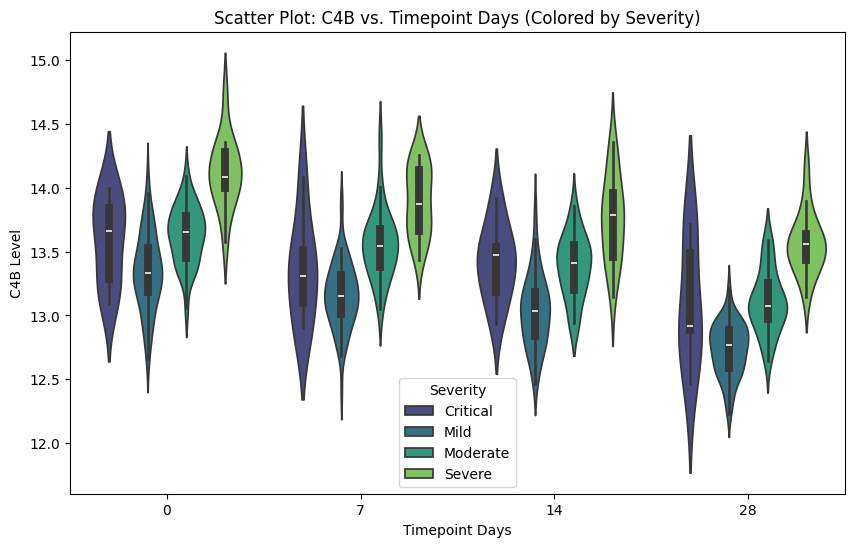

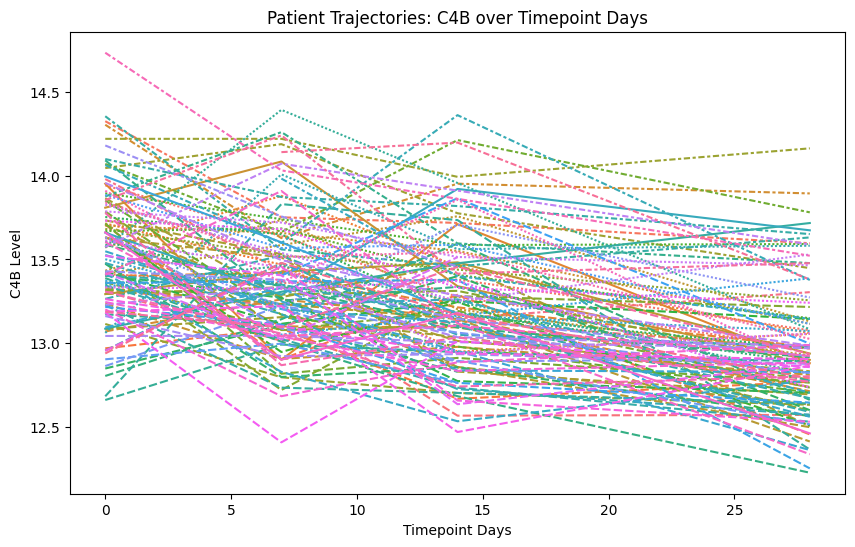

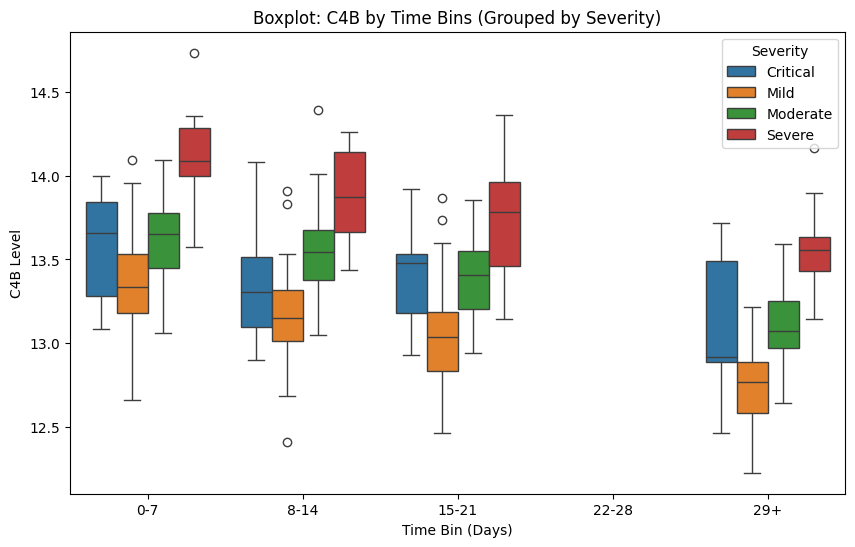

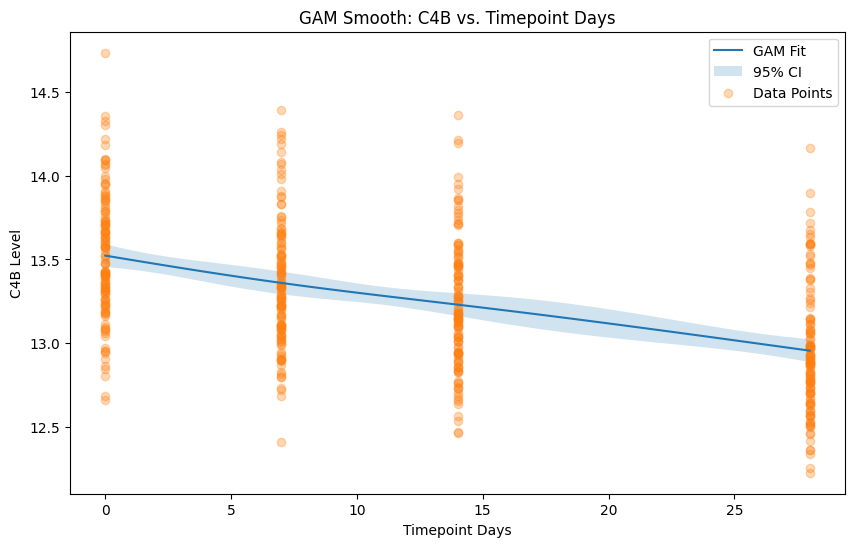

All plots for C4B generated and saved as PNG files.


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f
import pickle
import warnings
import ipywidgets as widgets
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -------------------------------
# Load data and previous outputs, ensuring severity_code is created
# -------------------------------
def load_data_and_outputs(data_file="COVID19_Plasma_Proteomics_2021_Samples.csv",
                          results_file="protein_gamm_results.csv",
                          gam_file="gam_models.pkl"):
    try:
        df = pd.read_csv(data_file)
        results_df = pd.read_csv(results_file)
        with open(gam_file, "rb") as f:
            gam_models = pickle.load(f)
    except Exception as e:
        raise ValueError(f"Error loading data or models: {str(e)}")

    df["timepoint_days"] = pd.to_numeric(df["timepoint_days"], errors="coerce")

    expected_categories = ["Mild", "Moderate", "Severe", "Critical"]
    if "severity_at_sample" in df.columns:
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")
        if "severity_code" not in df.columns:
            df["severity_code"] = df["severity_at_sample"].cat.codes
        else:
            code_mapping = df[["severity_at_sample", "severity_code"]].drop_duplicates()
            if len(code_mapping) != len(df["severity_at_sample"].cat.categories):
                print("Warning: Mismatch between severity_at_sample and severity_code")
    else:
        raise ValueError("Column 'severity_at_sample' not found in DataFrame")

    metadata_columns = [
        "patient_id", "sample_id", "timepoint_days", "collection_date",
        "age", "sex", "baseline_severity", "severity_at_sample",
        "viral_load_log10_copies", "severity_code"
    ]

    protein_columns = [
        col for col in df.columns
        if col not in metadata_columns and pd.api.types.is_numeric_dtype(df[col])
    ]

    if "C4B" not in protein_columns:
        raise ValueError("Protein 'C4B' not found in DataFrame columns")

    return df, results_df, gam_models, protein_columns

# -------------------------------
# Plot 1: Scatter plot of protein levels vs. timepoint_days, colored by severity
# -------------------------------
def plot_scatter_vs_time(df, protein, output_file=None):
    try:
        if protein not in df.columns:
            raise ValueError(f"Protein '{protein}' not found in DataFrame")
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=df, x="timepoint_days", y=protein, hue="severity_at_sample", palette="viridis")
        plt.title(f"Scatter Plot: {protein} vs. Timepoint Days (Colored by Severity)")
        plt.xlabel("Timepoint Days")
        plt.ylabel(f"{protein} Level")
        plt.legend(title="Severity")
        if output_file:
            plt.savefig(output_file)
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in plot_scatter_vs_time for {protein}: {str(e)}")

# -------------------------------
# Plot 2: Line plot (spaghetti plot) for protein trajectories over time per patient
# -------------------------------
def plot_trajectories_per_patient(df, protein, output_file=None):
    try:
        if protein not in df.columns:
            raise ValueError(f"Protein '{protein}' not found in DataFrame")
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x="timepoint_days", y=protein, hue="patient_id", style="severity_at_sample", legend=False)
        plt.title(f"Patient Trajectories: {protein} over Timepoint Days")
        plt.xlabel("Timepoint Days")
        plt.ylabel(f"{protein} Level")
        if output_file:
            plt.savefig(output_file)
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in plot_trajectories_per_patient for {protein}: {str(e)}")

# -------------------------------
# Plot 3: Boxplot of protein levels by binned timepoints, grouped by severity
# -------------------------------
def plot_boxplot_by_time_bins(df, protein, bins=[0, 7, 14, 21, 28, np.inf], bin_labels=["0-7", "8-14", "15-21", "22-28", "29+"], output_file=None):
    try:
        if protein not in df.columns:
            raise ValueError(f"Protein '{protein}' not found in DataFrame")
        df = df.copy()
        df["time_bin"] = pd.cut(df["timepoint_days"], bins=bins, labels=bin_labels, right=False)
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x="time_bin", y=protein, hue="severity_at_sample")
        plt.title(f"Boxplot: {protein} by Time Bins (Grouped by Severity)")
        plt.xlabel("Time Bin (Days)")
        plt.ylabel(f"{protein} Level")
        plt.legend(title="Severity")
        if output_file:
            plt.savefig(output_file)
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in plot_boxplot_by_time_bins for {protein}: {str(e)}")

# -------------------------------
# Plot 4: GAM smooth curve of protein vs. timepoint_days
# -------------------------------
def plot_gam_vs_time(df, protein, n_points=100, output_file=None):
    try:
        if protein not in df.columns:
            raise ValueError(f"Protein '{protein}' not found in DataFrame")
        df_subset = df.dropna(subset=[protein, "timepoint_days"])
        if len(df_subset) < 10:
            print(f"Skipping GAM plot for {protein}: Too few data points")
            if output_file:
                plt.figure(figsize=(1, 1))
                plt.savefig(output_file)
                plt.close()
            return

        X = df_subset[["timepoint_days"]].values
        y = df_subset[protein].values
        gam = LinearGAM(s(0, n_splines=10)).fit(X, y)

        time_grid = np.linspace(df_subset["timepoint_days"].min(), df_subset["timepoint_days"].max(), n_points)
        pred = gam.predict(time_grid)
        conf_intervals = gam.confidence_intervals(time_grid.reshape(-1, 1))

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, pred, label="GAM Fit")
        plt.fill_between(time_grid, conf_intervals[:, 0], conf_intervals[:, 1], alpha=0.2, label="95% CI")
        plt.scatter(df_subset["timepoint_days"], y, alpha=0.3, label="Data Points")
        plt.title(f"GAM Smooth: {protein} vs. Timepoint Days")
        plt.xlabel("Timepoint Days")
        plt.ylabel(f"{protein} Level")
        plt.legend()
        if output_file:
            plt.savefig(output_file)
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in plot_gam_vs_time for {protein}: {str(e)}")



# -------------------------------
# Main execution
# -------------------------------
if __name__ == "__main__":
    try:
        df, results_df, gam_models, protein_columns = load_data_and_outputs()

        # Single protein
        protein = "C4B"
        print(f"\nGenerating plots for {protein}")

        plot_scatter_vs_time(df, protein, output_file=f"{protein}_scatter_vs_time.png")
        plot_trajectories_per_patient(df, protein, output_file=f"{protein}_trajectories.png")
        plot_boxplot_by_time_bins(df, protein, output_file=f"{protein}_boxplot_time_bins.png")
        plot_gam_vs_time(df, protein, output_file=f"{protein}_gam_vs_time.png")

        print(f"All plots for {protein} generated and saved as PNG files.")



    except Exception as e:
        print(f"Error in main execution: {str(e)}")

Partial Dependence Plot for severity_at_sample (Bar Plot)

GAM model terms: f(0) + intercept
Severity levels: Index(['Critical', 'Mild', 'Moderate', 'Severe'], dtype='object')
Severity codes: [0 1 2 3]
Partial dependence values: [-0.03741092 -0.35659242 -0.00631008  0.40031375]


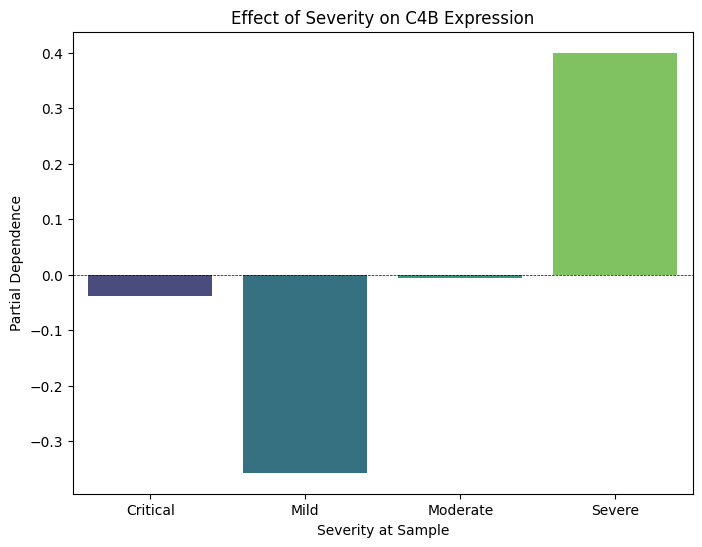

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots display in Jupyter
%matplotlib inline

def plot_severity_partial_dependence(df, protein, gam):
    try:
        severity_levels = df["severity_at_sample"].cat.categories
        severity_codes = np.unique(df["severity_code"])
        print(f"Severity levels: {severity_levels}")
        print(f"Severity codes: {severity_codes}")
        partial_dep = gam.partial_dependence(term=0, X=severity_codes)
        print(f"Partial dependence values: {partial_dep}")

        plt.figure(figsize=(8, 6))
        sns.barplot(x=severity_levels, y=partial_dep, hue=severity_levels, palette="viridis", legend=False)
        plt.title(f"Effect of Severity on {protein} Expression")
        plt.xlabel("Severity at Sample")
        plt.ylabel("Partial Dependence")
        plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {str(e)}")

# Test for C4B
protein = "C4B"
gam, _ = fit_gamm_model(df, response=protein)  # Assumes fit_gamm_model from your script
if gam is not None:
    print(f"GAM model terms: {gam.terms}")
    plot_severity_partial_dependence(df, protein, gam)
else:
    print(f"Failed to fit GAM model for {protein}")

Heatmap

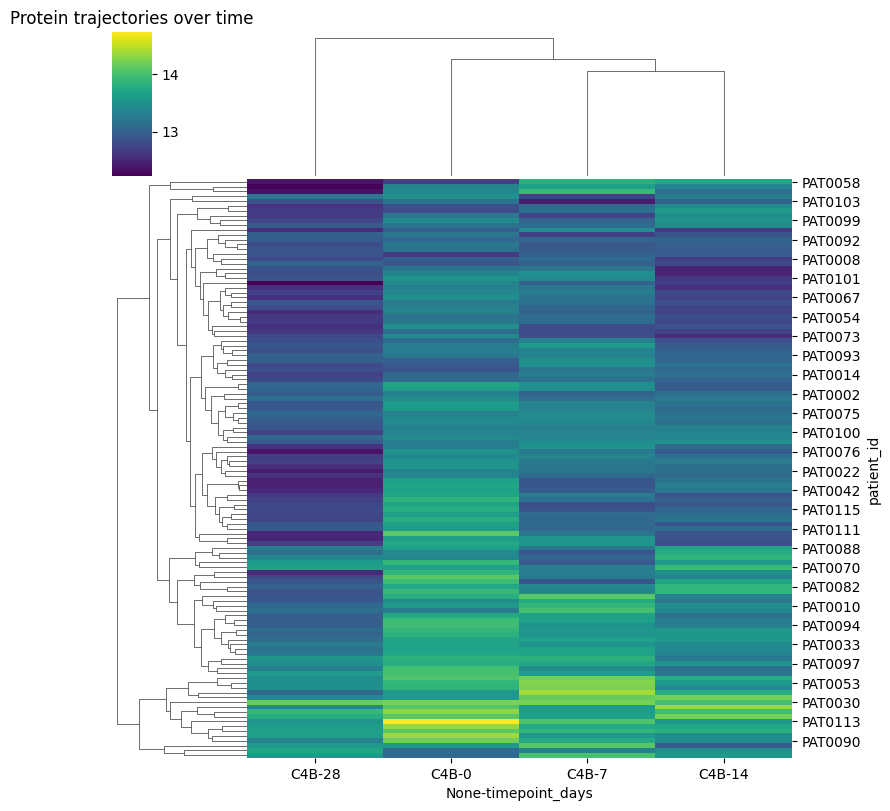

In [50]:
def heatmap_by_time(df, proteins):
    pivot_df = df.pivot_table(index="patient_id", columns="timepoint_days", values=proteins)
    sns.clustermap(pivot_df.fillna(pivot_df.mean()), cmap="viridis", figsize=(8, 8))
    plt.title("Protein trajectories over time")
    plt.show()

# Example with 5 proteins
heatmap_by_time(df, ["C4B"])


Random Effects Plot (Bar Plot)

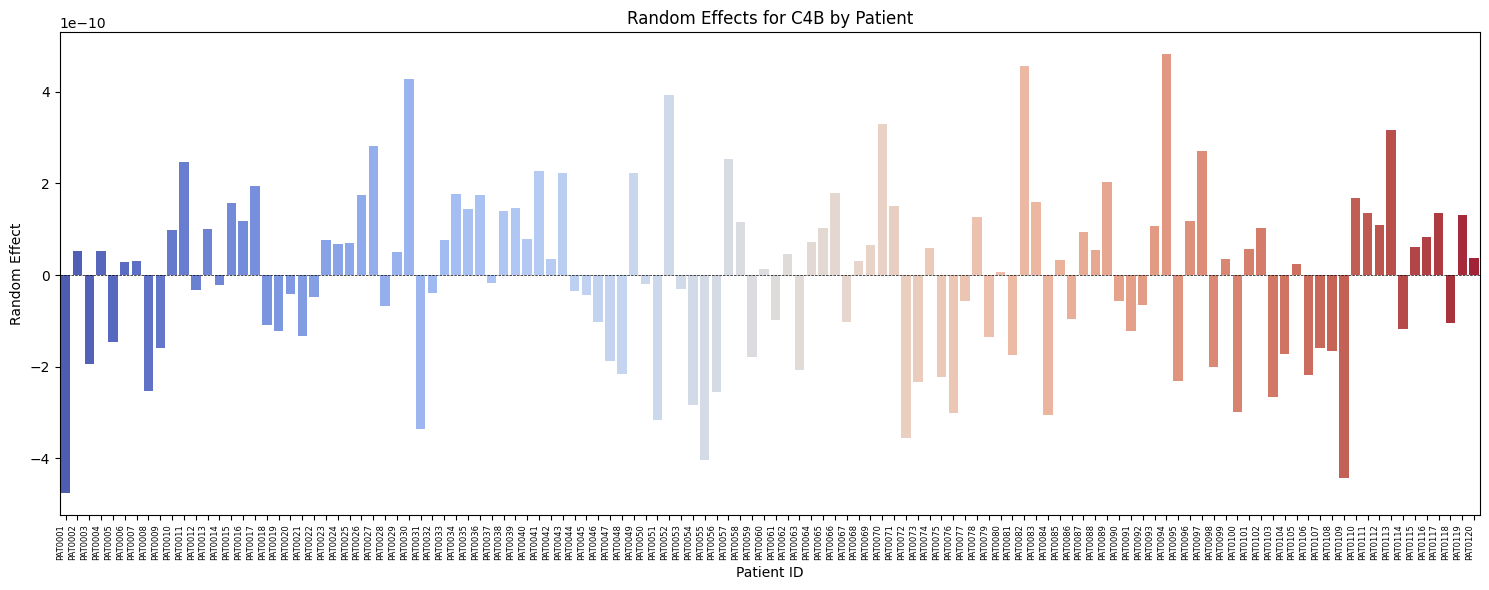

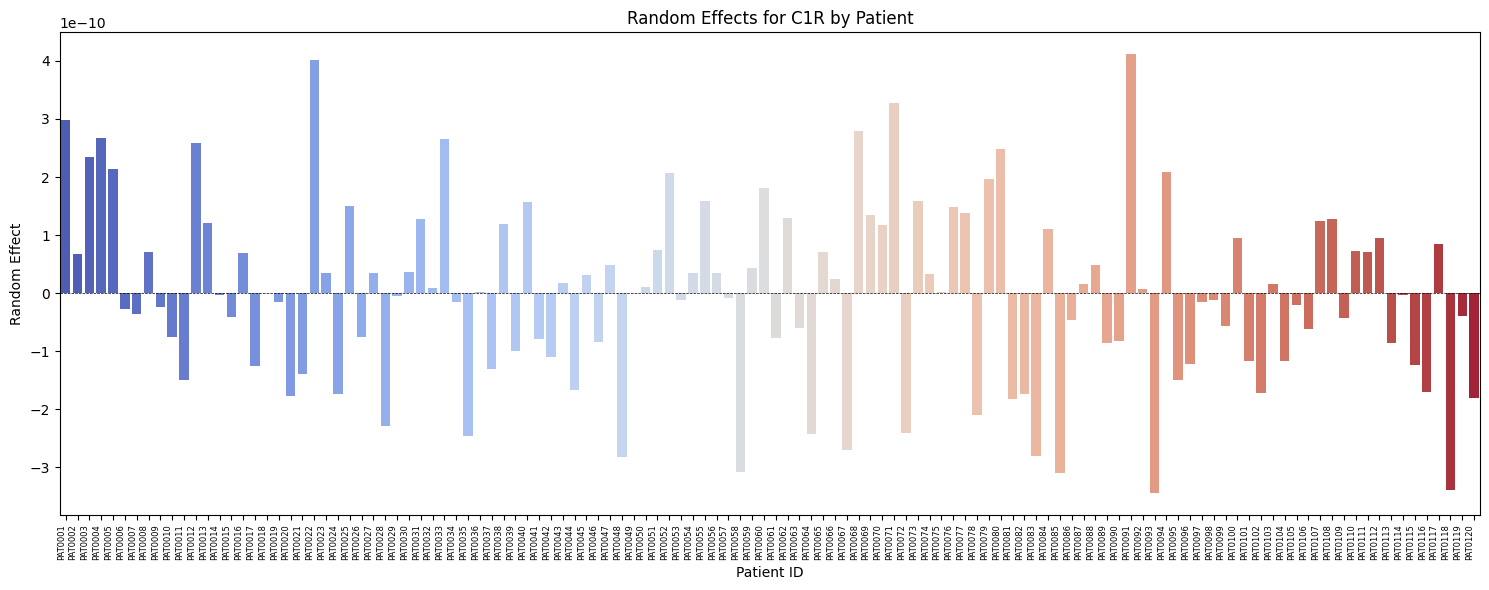

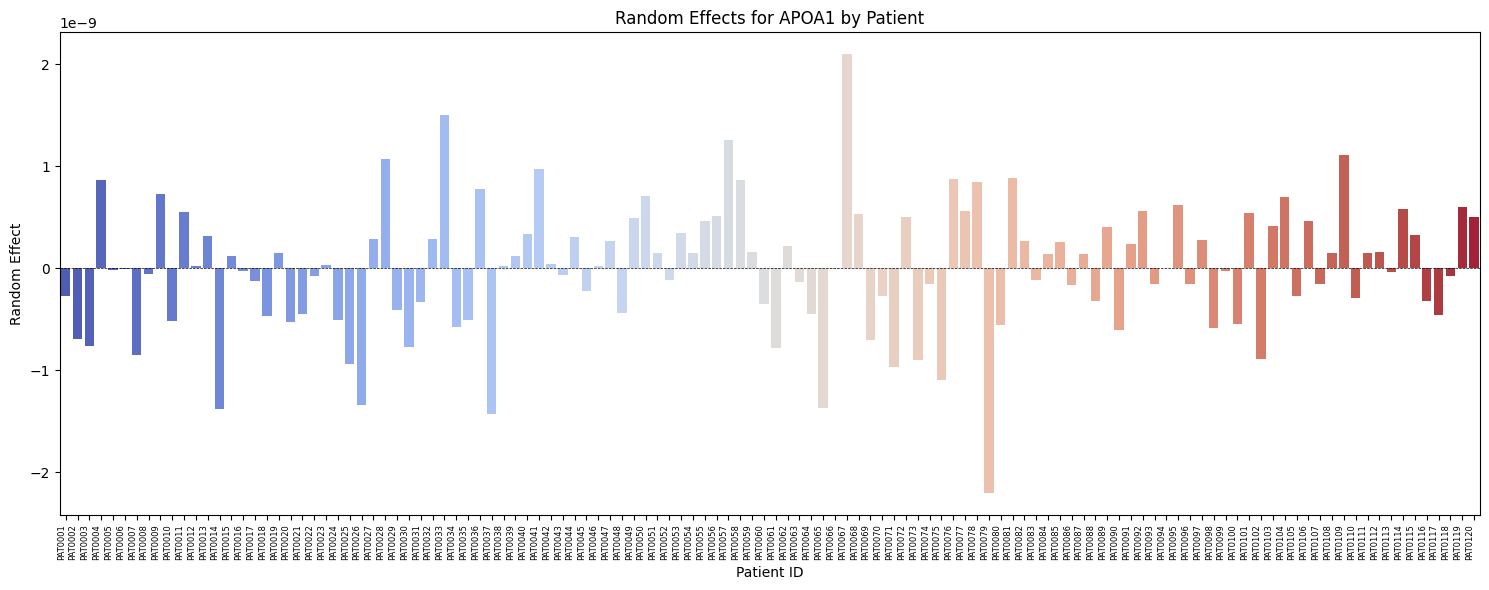

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_random_effects(df, protein, mixed_model):
    # Verify that the protein column exists in the DataFrame
    if protein not in df.columns:
        raise ValueError(f"Protein '{protein}' not found in DataFrame columns")

    # Extract random effects from the mixed model
    random_effects = mixed_model.random_effects
    patient_ids = list(random_effects.keys())
    effects = [random_effects[pid][0] for pid in patient_ids]

    # Create bar plot
    plt.figure(figsize=(15, 6))
    sns.barplot(x=patient_ids, y=effects, hue=patient_ids, palette="coolwarm", legend=False)
    plt.title(f"Random Effects for {protein} by Patient")
    plt.xlabel("Patient ID")
    plt.ylabel("Random Effect")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=90, ha="right", fontsize=6)
    plt.tight_layout()
    plt.show()

# Function to plot random effects for multiple proteins
def plot_random_effects_multiple(df, proteins):
    for protein in proteins:
        # Check if protein exists in DataFrame
        if protein not in df.columns:
            print(f"Warning: Protein '{protein}' not found in DataFrame. Skipping.")
            continue

        # Fit the GAMM model for the protein
        _, mixed_model = fit_gamm_model(df, response=protein)

        # Plot random effects if model fitting was successful
        if mixed_model is not None:
            plot_random_effects(df, protein, mixed_model)
        else:
            print(f"Warning: Failed to fit model for protein '{protein}'. Skipping.")

# Example usage
# Assuming df is loaded from the CSV and fit_gamm_model is defined
# df = pd.read_csv("COVID19_Plasma_Proteomics_2021_Samples.csv")

# Plot for multiple proteins (e.g., C4B, C1R, APOA1)
proteins = ["C4B", "C1R", "APOA1"]
plot_random_effects_multiple(df, proteins)

Predicted vs. Observed Values (Scatter Plot)

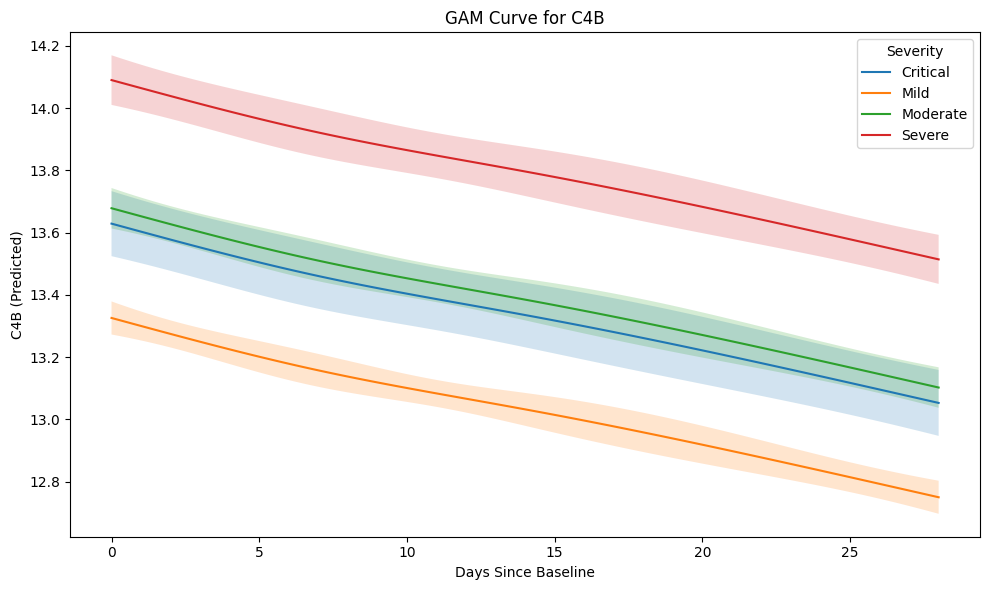

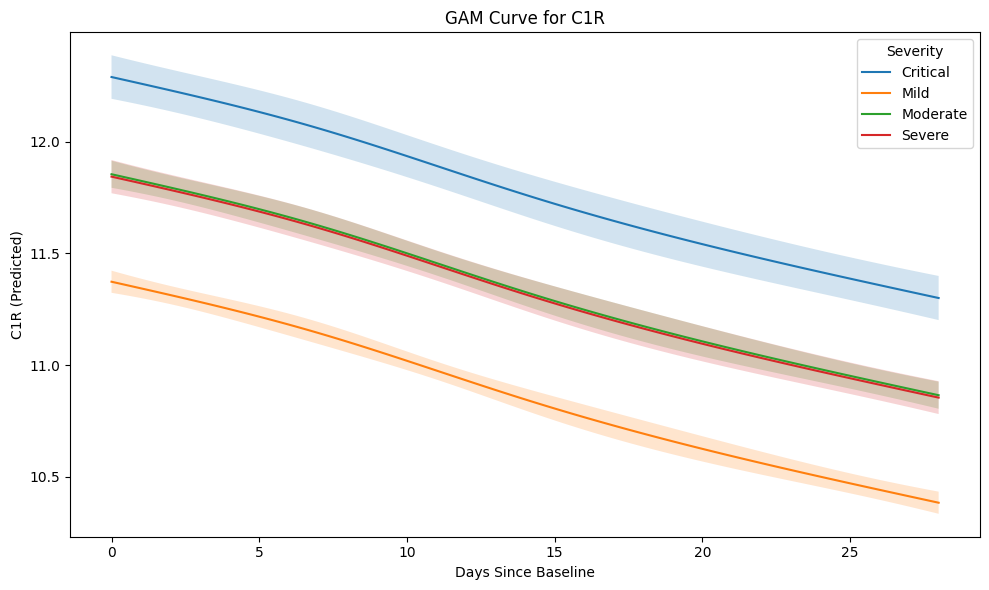

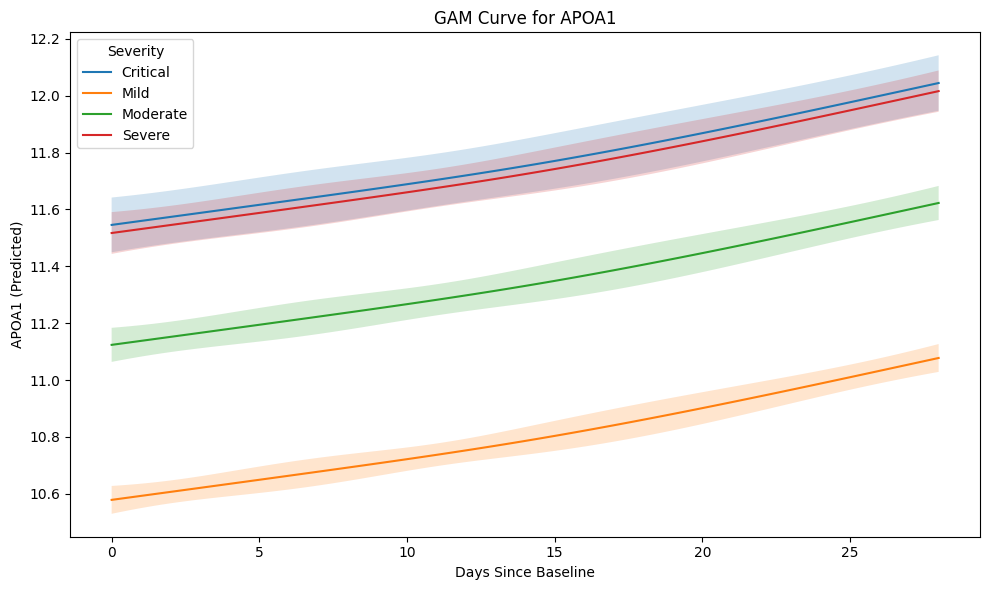

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

def gam_curve_over_time(df, protein, gam, severity_col="severity_at_sample", time_col="timepoint_days"):
    """
    Plot GAM curve over time for a single protein across severity levels.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe with metadata and protein values.
    protein : str
        Name of the protein to plot.
    gam : LinearGAM
        Fitted GAM model for this protein.
    severity_col : str
        Column containing severity categories (default: 'severity_at_sample').
    time_col : str
        Column containing time in days (default: 'timepoint_days').
    """
    # Validate columns
    for col in [protein, severity_col, time_col]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Ensure severity_col is categorical
    if not pd.api.types.is_categorical_dtype(df[severity_col]):
        df[severity_col] = df[severity_col].astype('category')

    # Generate evenly spaced time values
    time_values = np.linspace(df[time_col].min(), df[time_col].max(), 100)

    plt.figure(figsize=(10, 6))

    # Iterate through severity groups
    for severity_code, severity_label in enumerate(df[severity_col].cat.categories):
        X = np.column_stack([
            np.repeat(severity_code, len(time_values)),  # severity fixed
            time_values                                 # varying time
        ])

        # Predictions with confidence intervals
        pred = gam.predict(X)
        ci = gam.confidence_intervals(X, width=0.95)

        plt.plot(time_values, pred, label=severity_label)
        plt.fill_between(time_values, ci[:, 0], ci[:, 1], alpha=0.2)

    plt.title(f"GAM Curve for {protein}")
    plt.xlabel("Days Since Baseline")
    plt.ylabel(f"{protein} (Predicted)")
    plt.legend(title="Severity")
    plt.tight_layout()
    plt.show()

def fit_gam_model(df, protein, severity_col="severity_at_sample", time_col="timepoint_days"):
    """
    Fit a GAM model for a given protein.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with protein and metadata.
    protein : str
        Name of the protein to model.
    severity_col : str
        Column containing severity categories.
    time_col : str
        Column containing time in days.

    Returns
    -------
    LinearGAM or None
        Fitted GAM model or None if fitting fails.
    """
    try:
        # Ensure severity is categorical and get codes
        if not pd.api.types.is_categorical_dtype(df[severity_col]):
            df[severity_col] = df[severity_col].astype('category')

        X = np.column_stack([
            df[severity_col].cat.codes,
            df[time_col]
        ])
        y = df[protein]

        # Fit GAM with smooth term for time and factor for severity
        gam = LinearGAM(f(0) + s(1)).fit(X, y)
        return gam
    except Exception as e:
        print(f"Error fitting GAM model for {protein}: {e}")
        return None

def plot_gam_curves_multiple(df, proteins, severity_col="severity_at_sample", time_col="timepoint_days"):
    """
    Plot GAM curves for multiple proteins.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with protein and metadata.
    proteins : list
        List of protein names to plot.
    severity_col : str
        Column containing severity categories.
    time_col : str
        Column containing time in days.
    """
    for protein in proteins:
        if protein not in df.columns:
            print(f"Warning: Protein '{protein}' not found in DataFrame. Skipping.")
            continue

        # Fit GAM model
        gam = fit_gam_model(df, protein, severity_col, time_col)

        if gam is not None:
            gam_curve_over_time(df, protein, gam, severity_col, time_col)
        else:
            print(f"Warning: Failed to fit GAM model for {protein}. Skipping.")

# Example usage
# Assuming df is loaded from the CSV
# df = pd.read_csv("COVID19_Plasma_Proteomics_2021_Samples.csv")

# # Single protein
# protein = "C4B"
# gam = fit_gam_model(df, protein)
# if gam is not None:
#     gam_curve_over_time(df, protein, gam)

# Multiple proteins
proteins = ["C4B", "C1R", "APOA1"]
plot_gam_curves_multiple(df, proteins)

**Backup Codes (Not Checked)**

In [22]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Function to load and preprocess the dataset
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)
        required_columns = ["patient_id", "severity_at_sample"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Convert severity_at_sample to categorical
        expected_categories = ["Moderate", "Mild", "Critical", "Severe"]
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")

        # Encode severity_at_sample as numerical for pygam
        df["severity_code"] = df["severity_at_sample"].cat.codes

        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# Function to fit GAMM model for a single protein
def fit_gamm_model(df, response, predictor="severity_at_sample", random_effect="patient_id"):
    try:
        # Drop rows with missing values for the response variable
        df_subset = df.dropna(subset=[response, predictor, random_effect])
        if len(df_subset) < 10:  # Ensure enough data points
            raise ValueError("Too few valid data points after dropping missing values")

        # Fit GAM using pygam
        X = df_subset[["severity_code"]].values
        y = df_subset[response].values
        gam = LinearGAM(f(0)).fit(X, y)

        # Extract GAM predictions
        df_subset["gam_pred"] = gam.predict(X)

        # Fit mixed-effects model
        formula = f"{response} ~ gam_pred"
        model = smf.mixedlm(formula, df_subset, groups=df_subset[random_effect])
        result = model.fit()

        return gam, result
    except Exception as e:
        print(f"Error fitting GAMM for {response}: {str(e)}")
        return None, None

# Function to analyze all proteins
def analyze_all_proteins(df):
    # Identify protein columns (exclude metadata)
    metadata_columns = ["patient_id", "sample_id", "timepoint_days", "collection_date",
                       "age", "sex", "baseline_severity", "severity_at_sample",
                       "viral_load_log10_copies", "severity_code"]
    protein_columns = [col for col in df.columns if col not in metadata_columns and df[col].dtype in [np.float64, np.int64]]

    results = []
    for protein in protein_columns:
        print(f"\nAnalyzing protein: {protein}")
        gam, mixed_model = fit_gamm_model(df, response=protein)
        if gam is not None and mixed_model is not None:
            # Extract key results
            gam_p_value = gam.statistics_["p_values"][0] if gam.statistics_["p_values"] else np.nan
            r_squared = gam.statistics_["pseudo_r2"]["explained_deviance"]
            group_var = mixed_model.scale if hasattr(mixed_model, 'scale') else np.nan
            gam_pred_coef = mixed_model.params.get("gam_pred", np.nan)
            gam_pred_pval = mixed_model.pvalues.get("gam_pred", np.nan)

            # Partial dependence for severity levels
            severity_codes = np.unique(df["severity_code"])
            partial_dep = gam.partial_dependence(term=0, X=severity_codes)
            partial_dep_dict = {
                df["severity_at_sample"].cat.categories[code]: effect
                for code, effect in zip(severity_codes, partial_dep)
            }

            results.append({
                "Protein": protein,
                "GAM_P_Value": gam_p_value,
                "Pseudo_R_Squared": r_squared,
                "Group_Var": group_var,
                "Gam_Pred_Coef": gam_pred_coef,
                "Gam_Pred_P_Value": gam_pred_pval,
                **{f"Effect_{cat}": partial_dep_dict.get(cat, np.nan) for cat in ["Critical", "Mild", "Moderate", "Severe"]}
            })

            # Print partial dependence
            print(f"Partial Dependence for {protein}:")
            for cat, effect in partial_dep_dict.items():
                print(f"  Severity {cat}: Effect = {effect:.3f}")

    return pd.DataFrame(results)

# Main execution
if __name__ == "__main__":
    file_path = "COVID19_Plasma_Proteomics_2021_Samples.csv"
    try:
        # Load and preprocess data
        df = load_and_preprocess_data(file_path)
        print("Data loaded successfully. First few rows:")
        print(df[["patient_id", "severity_at_sample", "C4B"]].head())

        # Analyze all proteins
        results_df = analyze_all_proteins(df)
        print("\nSummary of Results for All Proteins:")
        print(results_df[["Protein", "GAM_P_Value", "Pseudo_R_Squared", "Group_Var",
                         "Effect_Critical", "Effect_Mild", "Effect_Moderate", "Effect_Severe"]])

        # Save results to CSV
        results_df.to_csv("protein_gamm_results.csv", index=False)
        print("Results saved to protein_gamm_results.csv")

    except Exception as e:
        print(f"Error: {str(e)}")

Data loaded successfully. First few rows:
  patient_id severity_at_sample      C4B
0    PAT0001             Severe  13.9804
1    PAT0001             Severe  13.3048
2    PAT0001             Severe  13.1471
3    PAT0001             Severe  13.4343
4    PAT0002               Mild  13.0136

Analyzing protein: C4B
Partial Dependence for C4B:
  Severity Critical: Effect = -0.037
  Severity Mild: Effect = -0.357
  Severity Moderate: Effect = -0.006
  Severity Severe: Effect = 0.400

Analyzing protein: C1R
Partial Dependence for C1R:
  Severity Critical: Effect = 0.473
  Severity Mild: Effect = -0.470
  Severity Moderate: Effect = 0.007
  Severity Severe: Effect = -0.010

Analyzing protein: C1S
Partial Dependence for C1S:
  Severity Critical: Effect = 0.302
  Severity Mild: Effect = -0.481
  Severity Moderate: Effect = 0.089
  Severity Severe: Effect = 0.091

Analyzing protein: APOA1
Partial Dependence for APOA1:
  Severity Critical: Effect = 0.340
  Severity Mild: Effect = -0.611
  Severity 

In [ ]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Function to load and preprocess the dataset
def load_and_preprocess_data(file_path):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Check for required columns
        required_columns = ["patient_id", "severity_at_sample", "C4B"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Convert severity_at_sample to categorical
        expected_categories = ["Moderate", "Mild", "Critical", "Severe"]
        df["severity_at_sample"] = df["severity_at_sample"].astype("category")
        invalid_categories = set(df["severity_at_sample"].cat.categories) - set(expected_categories)
        if invalid_categories:
            print(f"Warning: Found unexpected categories in severity_at_sample: {invalid_categories}")

        # Drop rows with missing values in required columns
        df = df.dropna(subset=required_columns)

        # Encode severity_at_sample as numerical for pygam
        df["severity_code"] = df["severity_at_sample"].cat.codes

        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found. Please ensure the file exists.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# Function to fit GAMM model
def fit_gamm_model(df, response="C4B", predictor="severity_at_sample", random_effect="patient_id"):
    try:
        # Fit GAM using pygam for the fixed effect (severity_at_sample)
        X = df[["severity_code"]].values
        y = df[response].values
        gam = LinearGAM(f(0)).fit(X, y)

        # Extract GAM predictions to use as an offset in mixed model
        df["gam_pred"] = gam.predict(X)

        # Fit mixed-effects model with statsmodels to include random effect
        formula = f"{response} ~ gam_pred"
        model = smf.mixedlm(formula, df, groups=df[random_effect])
        result = model.fit()

        # Print summary of mixed-effects model
        print(result.summary())

        # Return GAM and mixed-effects model for further inspection
        return gam, result
    except Exception as e:
        raise Exception(f"Error fitting GAMM model: {str(e)}")

# Main execution
if __name__ == "__main__":
    # Path to the CSV file (modify as needed)
    file_path = "COVID19_Plasma_Proteomics_2021_Samples.csv"

    # Load and preprocess data
    try:
        df = load_and_preprocess_data(file_path)
        print("Data loaded successfully. First few rows:")
        print(df[["patient_id", "severity_at_sample", "C4B"]].head())

        # Fit GAMM model
        gam_model, mixed_model = fit_gamm_model(df)
        print("\nGAM Model Summary:")
        print(gam_model.summary())

    except Exception as e:
        print(f"Error: {str(e)}")